## Edge Detection Processing

### General Configuration

#### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display

pd.set_option("max_colwidth", None)

#### Set Configs

In [2]:
ROOT_PATH = os.getcwd()
# ROOT_PATH

IMG_PATH = os.path.join(ROOT_PATH, "images")
# IMG_PATH

FILTERED_IMG_PATH = os.path.join(ROOT_PATH, "filtered")
# FILTERED_IMG_PATH

#### Set Image Path

In [3]:
# coins.ascii.pgm  --> P2, 300  246
# fruit.pgm        --> P5, 253 254
# saturn.ascii.pgm --> P2, 640 480

img_list = []
for idx, img in enumerate(os.listdir(IMG_PATH)):
    img_full_path = os.path.join(IMG_PATH, img)
    img_list.append([img, img_full_path])

# img_full_path = os.path.join(IMG_PATH, "coins.ascii.pgm")
# print(img_list)

pd.DataFrame(img_list, columns=['FileName', 'FullPath'])

FileName  \
0   coins.ascii.pgm   
1         fruit.pgm   
2  saturn.ascii.pgm   

                                                                                                 FullPath  
0   C:\Users\metin\Desktop\YTU\2024-Spring\3-BLM5113-SayisalVideoIsleme\HWorks\Hw1\images\coins.ascii.pgm  
1         C:\Users\metin\Desktop\YTU\2024-Spring\3-BLM5113-SayisalVideoIsleme\HWorks\Hw1\images\fruit.pgm  
2  C:\Users\metin\Desktop\YTU\2024-Spring\3-BLM5113-SayisalVideoIsleme\HWorks\Hw1\images\saturn.ascii.pgm

### Create or Define Functions for Digital Video Processing

#### Function: Read Image from PGM File

In [4]:
# Read Image from P2 PGM File
def read_p2_pgm_image(file_name):
    """
    Verilen dosyayı P2 formatında okuyarak numpy array olarak döndürür.

    Parametreler:
        file_name (str): Okunacak PGM dosyasının adı.

    Returns:
        numpy.ndarray: Okunan görüntü.
    """    
    with open(file_name) as f:
        lines = f.readlines()

    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)

    assert lines[0].strip() == 'P2'

    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])
    
    
    # Genişlik ve yükseklik değerlerini al
    height, width = (data[1], data[0])
    max_val = data[2]
    
    # Görüntüyü oku ve numpy array olarak dön
    img_ = np.array(data[3:])    
    img = np.reshape(img_, (height, width))
   
    return img, width, height, max_val

In [5]:
# Read Image from P5 PGM File
def read_p5_pgm_image(file_name):
    """
    Verilen dosyayı P5 formatında okuyarak numpy array olarak döndürür.

    Parametreler:
        file_name (str): Okunacak PGM dosyasının adı.

    Returns:
        numpy.ndarray: Okunan görüntü.
    """
    with open(file_name, 'rb') as f:
        header = f.readline().decode('utf-8')
        if header != "P5\n":
            raise ValueError("Geçersiz PGM formatı. Sadece P5 desteklenmektedir.")

        # Yorum satırlarını oku ve atla
        line = f.readline().decode('utf-8')
        while line.startswith("#"):
            line = f.readline().decode('utf-8')

        # Genişlik ve yükseklik değerlerini al
        width, height = map(int, line.split())

        # Max değerini oku ve normalize et
        max_val = int(f.readline().decode('utf-8'))

        # Görüntüyü oku ve numpy array olarak dön
        img = np.fromfile(f, dtype=np.uint8, count=width*height).reshape((height, width))

        return img, width, height, max_val

#### Function: Calculate Gaussian Distribution

In [6]:
def calc_gaussian_distribution(x, sigma):
    """
    Gaussian (normal) dağılım formülü.
    
    Parameters:
        x (float veya np.array): Dağılım için verilen giriş değer(i).
        sigma (float): Dağılımın standart sapması.
    
    Returns:
        float veya np.array: Verilen giriş için Gaussian dağılımının sonucu.
    """    
    exponent = -x ** 2 / (2 * sigma ** 2)
    coefficient = sigma * np.sqrt(2 * np.pi)
    result = np.exp(exponent) / coefficient
    return result

In [7]:
def gaussianX(x, sigma):
    return np.exp(-x**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi)) # formula

#### Function: Apply Gaussian Filter

In [8]:
def apply_gaussian_filter(image, sigma=1, size=1):
    """
    Görüntüye Gauss filtresi uygular.

    Parametreler:
    image (numpy.ndarray): Filtrelenmesi gereken görüntü.
    sigma (float): Gauss filtresinin standart sapması.

    Returns:
    numpy.ndarray: Filtrelenmiş görüntü.
    """
    # Görüntü boyutlarını al
    height, width = image.shape

    # Gauss filtresi
    kernel = np.zeros((size, size))
    center = size // 2
    for i in range(size):
        for j in range(size):
            kernel[i, j] = calc_gaussian_distribution(np.sqrt((i - center)**2 + (j - center)**2), sigma)

    # Normalization
    kernel /= np.sum(kernel)

    # Görüntüyü filtrele
    filtered_image = np.zeros_like(image)
    padded_image = np.pad(image, ((center, center), (center, center)), mode='constant')
    for i in range(height):
        for j in range(width):
            patch = padded_image[i:i+size, j:j+size]
            filtered_image[i, j] = np.sum(patch * kernel)

    return filtered_image

#### Function: Write Image as a PGM File

In [9]:
def write_pgm(file_name, image, width, height, max_val):
    with open(file_name, 'wb') as f:
        # PGM başlığı yaz
        f.write("P2\n".encode())
        f.write("# Generated by Python\n".encode())
        f.write(f"{width} {height}\n".encode())
        f.write(f"{max_val}\n".encode())

        # Görüntüyü yaz
        for row in image:
            for pixel in row:
                f.write(f"{pixel} ".encode())
            f.write(b"\n")

#### Function: Apply Sobel Filter

In [10]:
def apply_sobel_filter(image):
    gx = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])

    gy = np.array([[-1, -2, -1],
                    [0, 0, 0],
                    [1, 2, 1]])

    height, width = image.shape

    filtered_image = np.zeros_like(image, dtype=float)
    filtered_image_gx = np.zeros_like(image, dtype=float)
    filtered_image_gy = np.zeros_like(image, dtype=float)

    padded_image = np.pad(image, ((1, 1), (1, 1)), mode='constant')

    # Yatay ve dikey kenarlar
    for i in range(1, height + 1):
        for j in range(1, width + 1):
            region = padded_image[i - 1:i + 2, j - 1:j + 2]

            gradient_x = np.sum(region * gx)
            gradient_y = np.sum(region * gy)
            magnitude = np.sqrt(gradient_x**2 + gradient_y**2)

            filtered_image[i - 1, j - 1] = magnitude
            filtered_image_gy[i - 1, j - 1] = gradient_y
            filtered_image_gx[i - 1, j - 1] = gradient_x

    # return filtered_image, filtered_image_gx, filtered_image_gy
    return filtered_image_gx, filtered_image_gy, filtered_image

#### Function: Show PGM Image

In [11]:
def display_pgm(file_name):
    img = Image.open(file_name)
    display(img)

#### Function: Plot Images with Sobel Filter Applied

In [12]:
def plot_gradients_and_magnitude(img_list, title, gradient_x, gradient_y, edge_magnitude):
    """
    Verilen görüntü listesi, x ve y gradyanları, ve kenar büyüklüğü görüntülerini plotlar.

    Parametreler:
        img_list (list): Görüntü listesi.
        gradient_x (numpy.ndarray): X gradyanı görüntüsü.
        gradient_y (numpy.ndarray): Y gradyanı görüntüsü.
        edge_magnitude (numpy.ndarray): Kenar büyüklüğü görüntüsü.
    """
    plt.figure(figsize=(12, 8))
    # plt.suptitle(title)
    plt.title(title)

    # Plot Gradient X
    plt.subplot(1, 3, 1)
    plt.imshow(gradient_x, cmap='gray')
    plt.title('Gradient X')
    # plt.colorbar()

    # Plot Gradient Y
    plt.subplot(1, 3, 2)
    plt.imshow(gradient_y, cmap='gray')
    plt.title('Gradient Y')
    # plt.colorbar()

    # Plot Edge Magnitude
    plt.subplot(1, 3, 3)
    plt.imshow(edge_magnitude, cmap='gray')
    plt.title('Edge Magnitude')
    # plt.colorbar()

    plt.tight_layout()
    plt.show()

## Image-1: coins.ascii.pgm

### Read Image

In [13]:
# Show Each Image Name & Path
img_name, img_path = img_list[0][0], img_list[0][1]
print(f"ImageName: {img_name} & ImagePath: {img_path}")

# Create Specific Directory for Filtered Images
os.makedirs(os.path.join(FILTERED_IMG_PATH,img_name), exist_ok=True)

ImageName: coins.ascii.pgm & ImagePath: C:\Users\metin\Desktop\YTU\2024-Spring\3-BLM5113-SayisalVideoIsleme\HWorks\Hw1\images\coins.ascii.pgm


In [14]:
img_arr, width, height, max_val = read_p2_pgm_image(file_name=img_path)

In [15]:
img_arr.shape, width, height, max_val

((246, 300), 300, 246, 255)

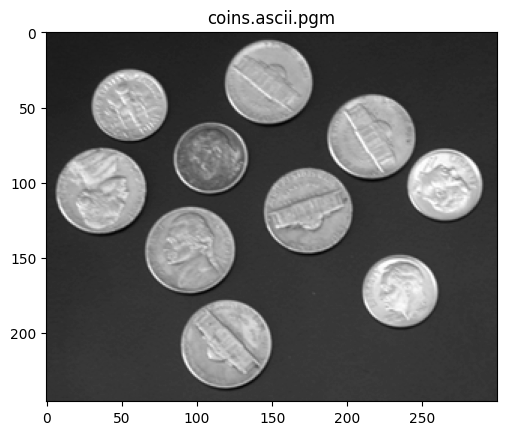

In [16]:
plt.imshow(img_arr, cmap="gray")
plt.title(img_name)
plt.show()

### Apply Gaussian Kernel

In [17]:
img_arr_gaussian_filtered = apply_gaussian_filter(image=img_arr, sigma=1, size=1)
img_arr_gaussian_filtered

array([[49, 50, 48, ..., 58, 55, 55],
       [47, 47, 49, ..., 56, 57, 55],
       [48, 48, 49, ..., 57, 56, 57],
       ...,
       [71, 70, 70, ..., 70, 69, 70],
       [69, 71, 71, ..., 70, 72, 71],
       [69, 68, 69, ..., 71, 72, 71]])

In [18]:
# img_arr

In [19]:
# plt.imshow(img_arr, cmap="gray")

In [20]:
# plt.imshow(img_arr_gauss_filtered, cmap="gray")

In [21]:
# Set Kernel Size and Sigma Values

kernel_sizes = [3, 5, 7]
sigmas = [1, 5]

kernel_sigma_values = [(a, b) for a in kernel_sizes for b in sigmas]
kernel_sigma_values

[(3, 1), (3, 5), (5, 1), (5, 5), (7, 1), (7, 5)]

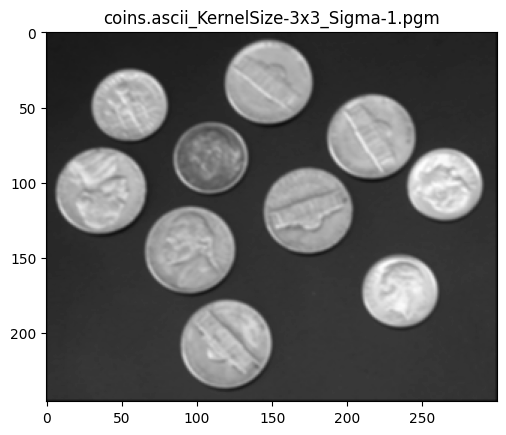

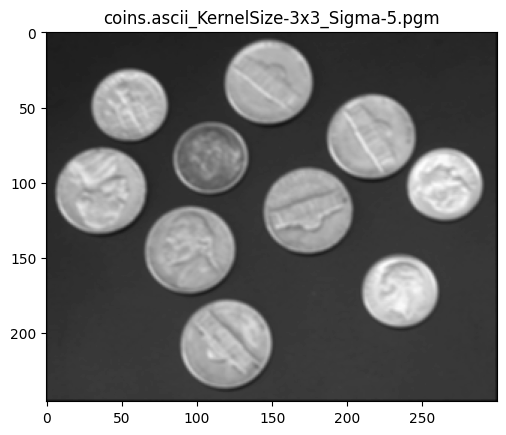

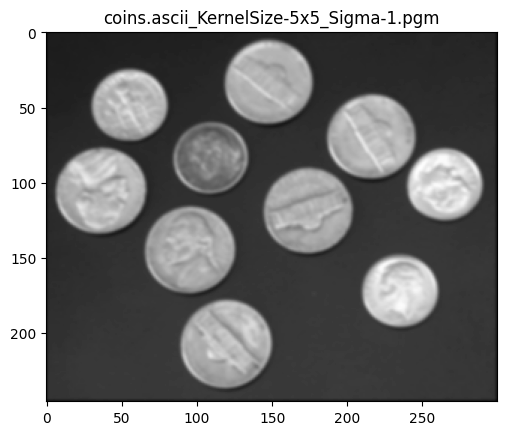

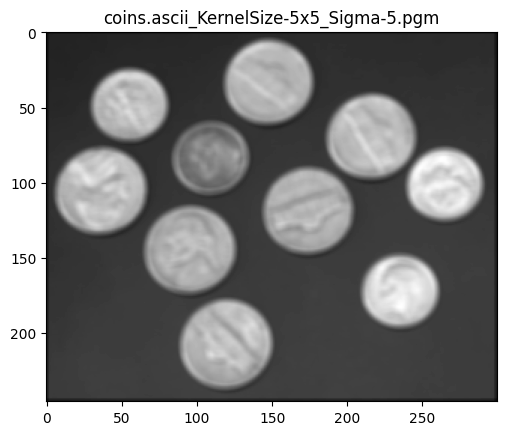

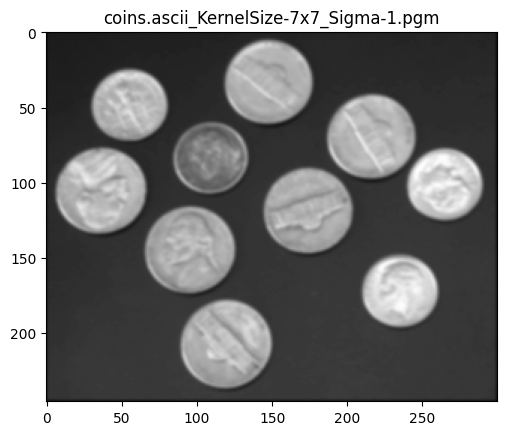

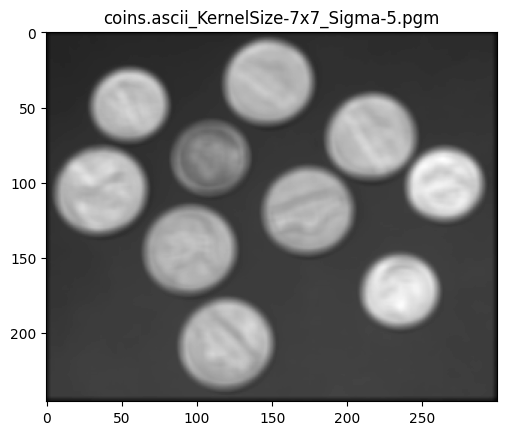

In [22]:
file_name, file_ext = os.path.splitext(img_name)[0], os.path.splitext(img_name)[1]

for i in kernel_sigma_values:
    img_filtered = apply_gaussian_filter(img_arr, size=i[0], sigma=i[1])
    f_n = f"{file_name}_KernelSize-{i[0]}x{i[0]}_Sigma-{i[1]}{file_ext}"
    f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
    write_pgm(file_name=f_p, image=img_filtered, width=width, height=height, max_val=max_val)
    plt.figure()
    plt.imshow(img_filtered, cmap="gray")
    plt.title(f_n)
    plt.show()

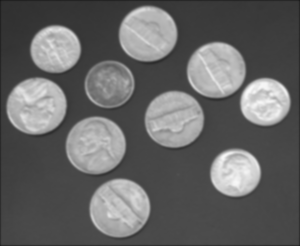

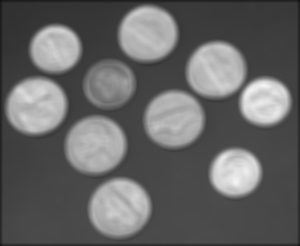

In [23]:
display_pgm(file_name="filtered/coins.ascii.pgm/coins.ascii_KernelSize-7x7_Sigma-1.pgm")
display_pgm(file_name="filtered/coins.ascii.pgm/coins.ascii_KernelSize-7x7_Sigma-5.pgm")

### Apply Sobel Filter

In [24]:
gradient_x, gradient_y, edge_magnitude = apply_sobel_filter(img_arr)

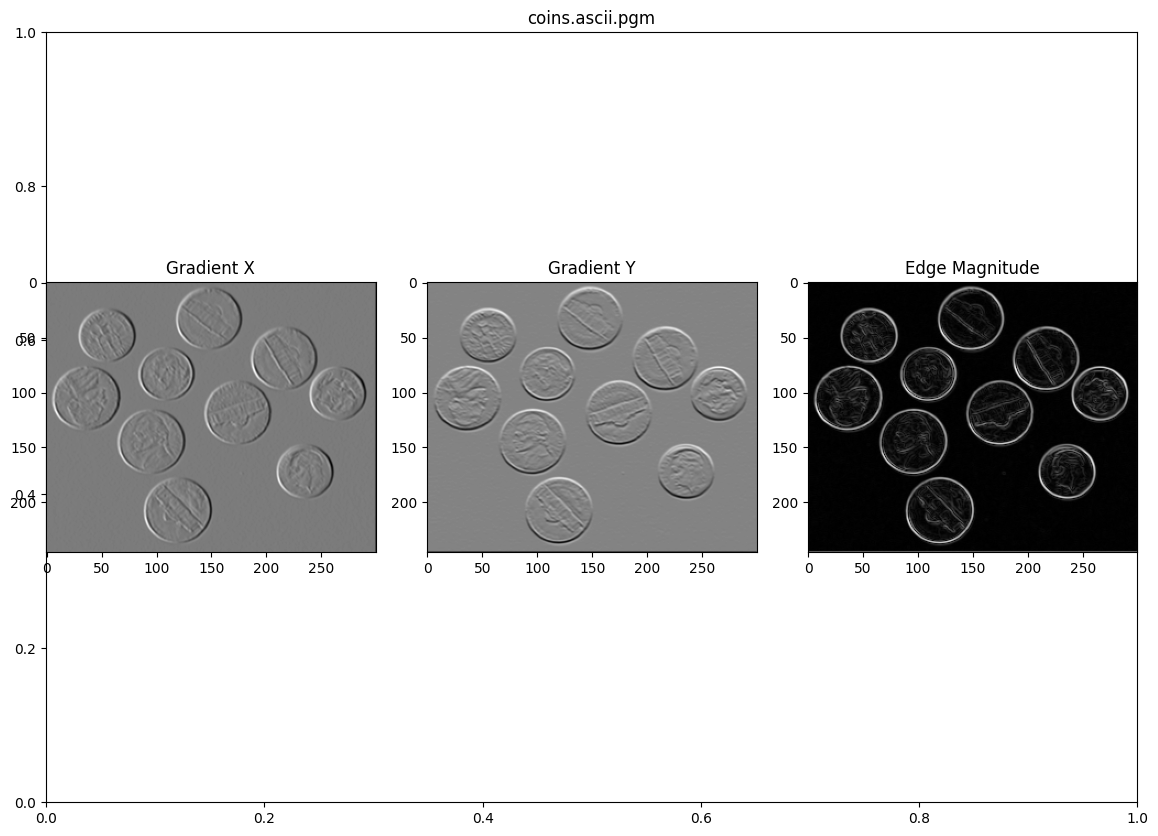

In [25]:
plot_gradients_and_magnitude(img_list=img_list, title=img_name, gradient_x=gradient_x, gradient_y=gradient_y, edge_magnitude=edge_magnitude)

In [26]:
# Save Images with Sobel Filter Applied

f_n = f"{file_name}_{'SobelFilter'}-{'Gradient_X'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=gradient_x, width=width, height=height, max_val=max_val)

f_n = f"{file_name}_{'SobelFilter'}-{'Gradient_Y'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=gradient_y, width=width, height=height, max_val=max_val)

f_n = f"{file_name}_{'SobelFilter'}-{'EdgeMagnitude'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=edge_magnitude, width=width, height=height, max_val=max_val)

In [27]:
# plt.figure()
# plt.imshow(gradient_y, cmap="gray")
# plt.title(str(img_name) + "---" + str("gradient_y"))
# plt.show()

### Apply Sobel Filter to Most Blurry Image

In [28]:
most_blurry_image = "filtered/coins.ascii.pgm/coins.ascii_KernelSize-7x7_Sigma-5.pgm"

img_name = os.path.splitext("coins.ascii_KernelSize-7x7_Sigma-5.pgm")[0]
img_path = most_blurry_image

print(f"ImageName: {img_name} & ImagePath: {img_path}")

# Create Specific Directory for Filtered Images
img_name_ = "most_blurry_image"
os.makedirs(os.path.join(FILTERED_IMG_PATH, img_name_), exist_ok=True)

ImageName: coins.ascii_KernelSize-7x7_Sigma-5 & ImagePath: filtered/coins.ascii.pgm/coins.ascii_KernelSize-7x7_Sigma-5.pgm


#### Read Image

In [29]:
img_arr, width, height, max_val = read_p2_pgm_image(file_name=img_path)

In [30]:
img_arr.shape, width, height, max_val

((246, 300), 300, 246, 255)

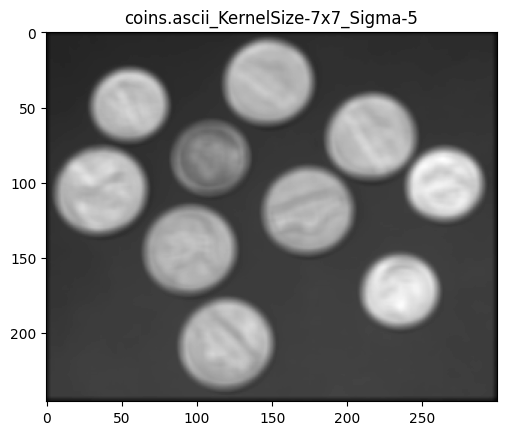

In [31]:
plt.imshow(img_arr, cmap="gray")
plt.title(img_name)
plt.show()

#### Apply Sobel Filter

In [32]:
gradient_x, gradient_y, edge_magnitude = apply_sobel_filter(img_arr)

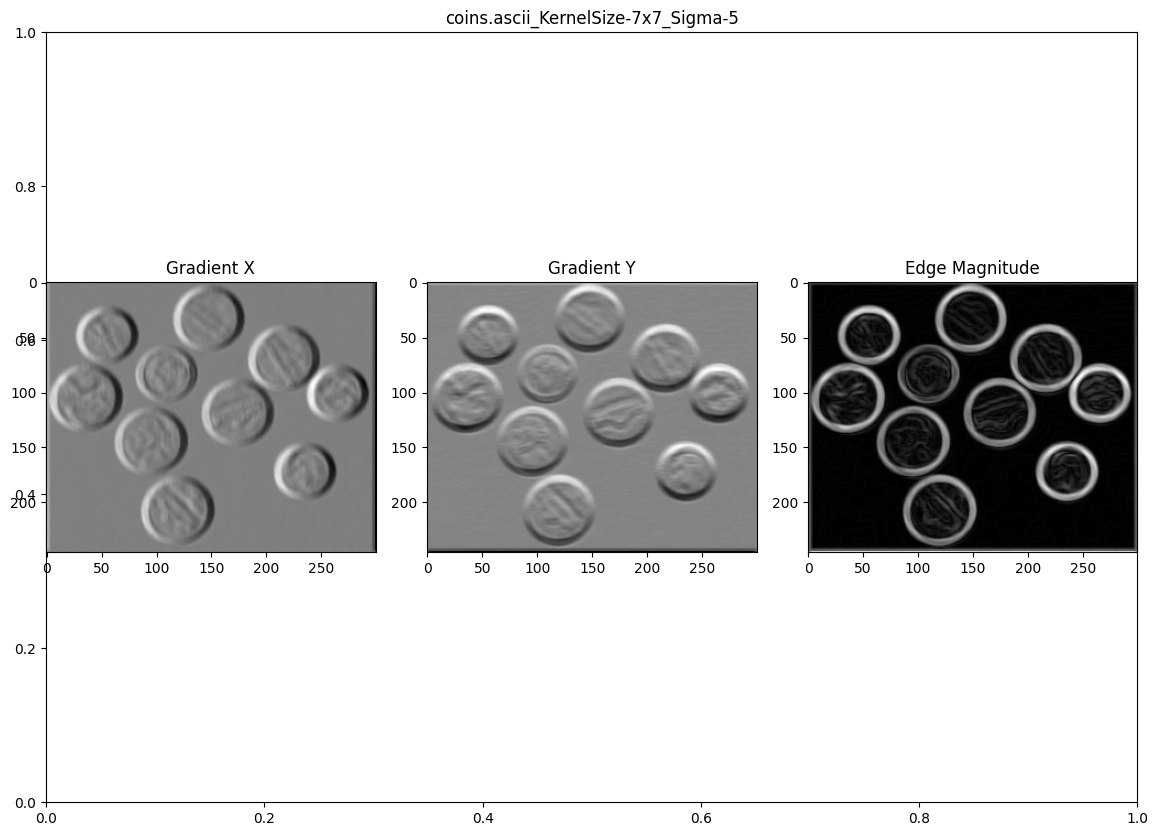

In [33]:
plot_gradients_and_magnitude(img_list=img_list, title=img_name, gradient_x=gradient_x, gradient_y=gradient_y, edge_magnitude=edge_magnitude)

In [34]:
# Save Images with Sobel Filter Applied

f_n = f"{img_name}_{'SobelFilter'}-{'Gradient_X'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=gradient_x, width=width, height=height, max_val=max_val)

f_n = f"{img_name}_{'SobelFilter'}-{'Gradient_Y'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=gradient_y, width=width, height=height, max_val=max_val)

f_n = f"{img_name}_{'SobelFilter'}-{'EdgeMagnitude'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=edge_magnitude, width=width, height=height, max_val=max_val)

## Image-2: fruit.pgm

### Read Image

In [35]:
img_name, img_path = img_list[1][0], img_list[1][1]
print(f"ImageName: {img_name} & ImagePath: {img_path}")

# Create Specific Directory for Filtered Images
os.makedirs(os.path.join(FILTERED_IMG_PATH,img_name), exist_ok=True)

ImageName: fruit.pgm & ImagePath: C:\Users\metin\Desktop\YTU\2024-Spring\3-BLM5113-SayisalVideoIsleme\HWorks\Hw1\images\fruit.pgm


In [36]:
# img_arr, width, height, max_val = read_pgm_image(img_path)
img_arr, width, height, max_val = read_p5_pgm_image(file_name=img_path)

In [37]:
img_arr

array([[192, 167, 167, ..., 145, 141, 167],
       [188, 223, 198, ..., 141, 145, 141],
       [223, 198, 223, ..., 120, 132, 145],
       ...,
       [188, 213, 192, ..., 177, 192, 155],
       [213, 167, 188, ..., 171, 155, 171],
       [188, 213, 188, ...,  93,  81,  93]], dtype=uint8)

In [38]:
img_arr.shape, width, height, max_val

((254, 253), 253, 254, 255)

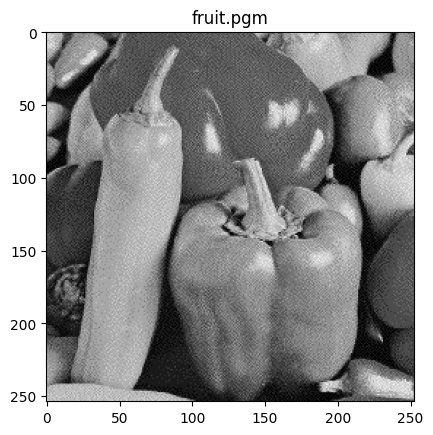

In [39]:
plt.imshow(img_arr, cmap="gray")
plt.title(img_name)
plt.show()

### Apply Gaussian Kernel

In [40]:
img_arr_gaussian_filtered = apply_gaussian_filter(image=img_arr, sigma=1, size=1)
img_arr_gaussian_filtered

array([[192, 167, 167, ..., 145, 141, 167],
       [188, 223, 198, ..., 141, 145, 141],
       [223, 198, 223, ..., 120, 132, 145],
       ...,
       [188, 213, 192, ..., 177, 192, 155],
       [213, 167, 188, ..., 171, 155, 171],
       [188, 213, 188, ...,  93,  81,  93]], dtype=uint8)

In [41]:
# img_arr

In [42]:
# plt.imshow(img_arr, cmap="gray")

In [43]:
# plt.imshow(img_arr_gauss_filtered, cmap="gray")

In [44]:
# Set Kernel Size and Sigma Values

kernel_sizes = [3, 5, 7]
sigmas = [1, 5]

kernel_sigma_values = [(a, b) for a in kernel_sizes for b in sigmas]
kernel_sigma_values

[(3, 1), (3, 5), (5, 1), (5, 5), (7, 1), (7, 5)]

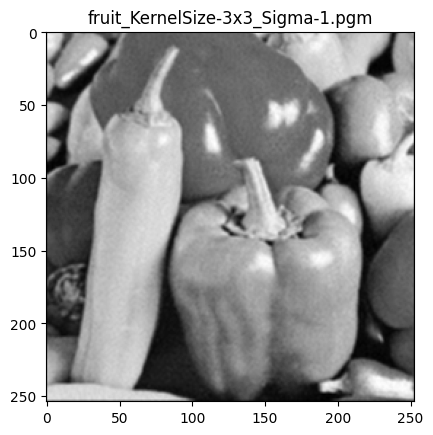

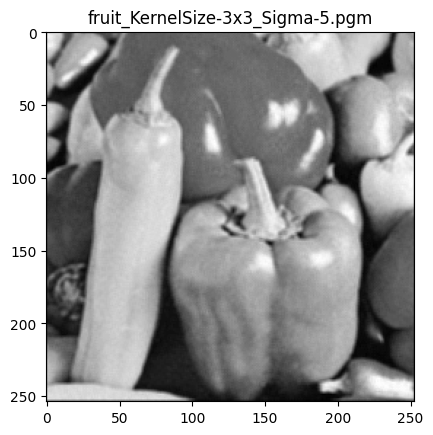

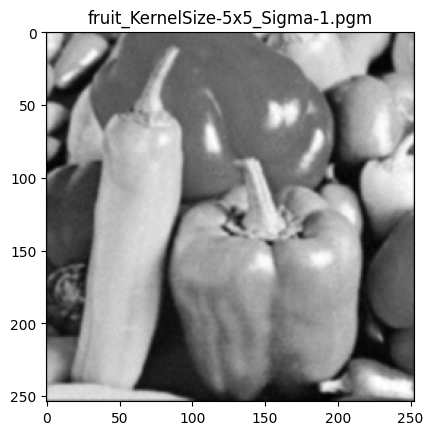

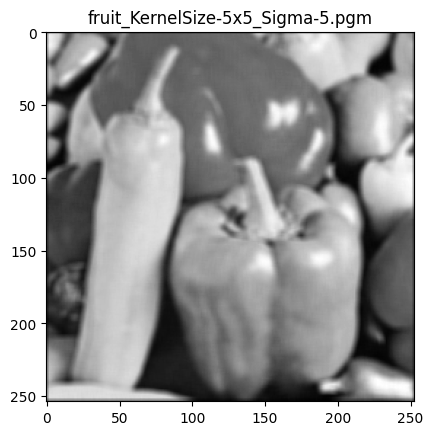

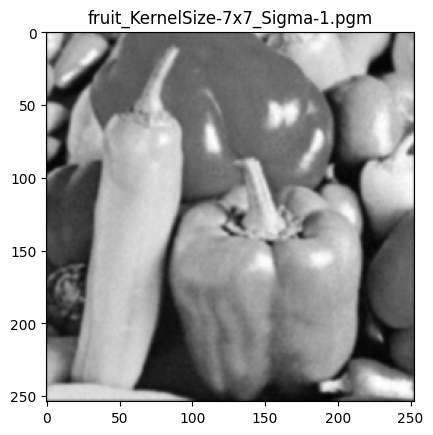

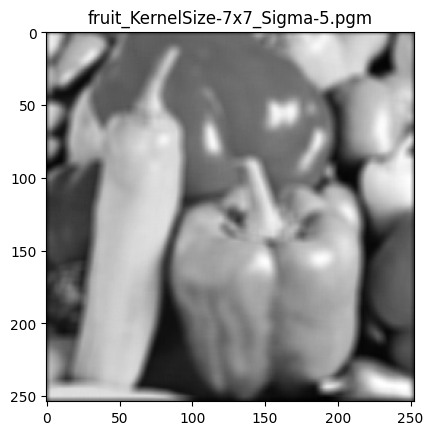

In [45]:
file_name, file_ext = os.path.splitext(img_name)[0], os.path.splitext(img_name)[1]

for i in kernel_sigma_values:
    img_filtered = apply_gaussian_filter(img_arr, size=i[0], sigma=i[1])
    f_n = f"{file_name}_KernelSize-{i[0]}x{i[0]}_Sigma-{i[1]}{file_ext}"
    f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
    write_pgm(file_name=f_p, image=img_filtered, width=width, height=height, max_val=max_val)
    plt.figure()
    plt.imshow(img_filtered, cmap="gray")
    plt.title(f_n)
    plt.show()

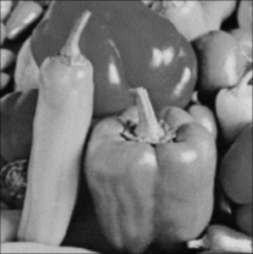

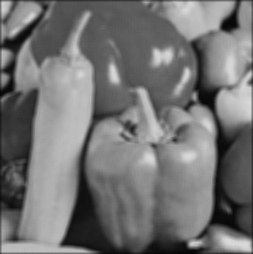

In [46]:
display_pgm(file_name="filtered/fruit.pgm/fruit_KernelSize-5x5_Sigma-1.pgm")
display_pgm(file_name="filtered/fruit.pgm/fruit_KernelSize-5x5_Sigma-5.pgm")

### Apply Sobel Filter

In [47]:
gradient_x, gradient_y, edge_magnitude = apply_sobel_filter(img_arr)

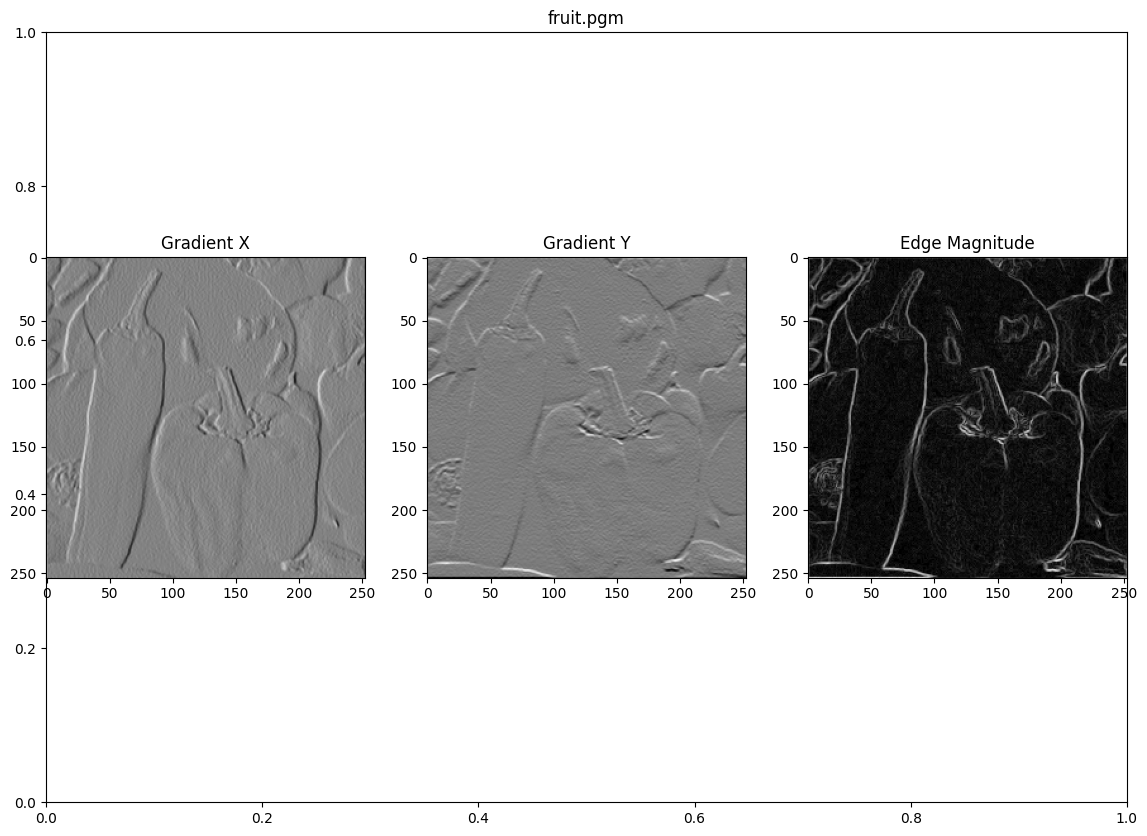

In [48]:
plot_gradients_and_magnitude(img_list=img_list, title=img_name, gradient_x=gradient_x, gradient_y=gradient_y, edge_magnitude=edge_magnitude)

In [49]:
# Save Images with Sobel Filter Applied

f_n = f"{file_name}_{'SobelFilter'}-{'Gradient_X'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=gradient_x, width=width, height=height, max_val=max_val)

f_n = f"{file_name}_{'SobelFilter'}-{'Gradient_Y'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=gradient_y, width=width, height=height, max_val=max_val)

f_n = f"{file_name}_{'SobelFilter'}-{'EdgeMagnitude'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=edge_magnitude, width=width, height=height, max_val=max_val)

In [50]:
# plt.figure()
# plt.imshow(gradient_y, cmap="gray")
# plt.title(str(img_name) + "---" + str("gradient_y"))
# plt.show()

### Apply Sobel Filter to Most Blurry Image

In [51]:
most_blurry_image = "filtered/fruit.pgm/fruit_KernelSize-7x7_Sigma-5.pgm"

img_name = os.path.splitext("fruit_KernelSize-7x7_Sigma-5.pgm")[0]
img_path = most_blurry_image

print(f"ImageName: {img_name} & ImagePath: {img_path}")

# Create Specific Directory for Filtered Images
img_name_ = "most_blurry_image"
os.makedirs(os.path.join(FILTERED_IMG_PATH, img_name_), exist_ok=True)

ImageName: fruit_KernelSize-7x7_Sigma-5 & ImagePath: filtered/fruit.pgm/fruit_KernelSize-7x7_Sigma-5.pgm


#### Read Image

In [52]:
img_arr, width, height, max_val = read_p2_pgm_image(file_name=img_path)

In [53]:
img_arr.shape, width, height, max_val

((254, 253), 253, 254, 255)

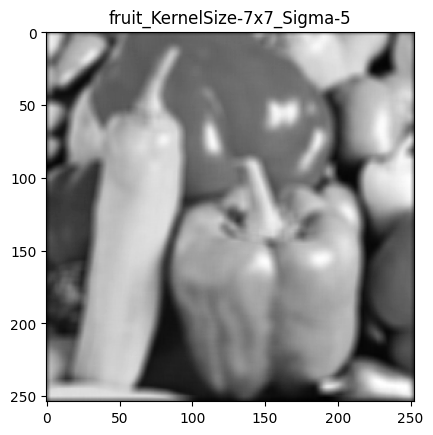

In [54]:
plt.imshow(img_arr, cmap="gray")
plt.title(img_name)
plt.show()

#### Apply Sobel Filter

In [55]:
gradient_x, gradient_y, edge_magnitude = apply_sobel_filter(img_arr)

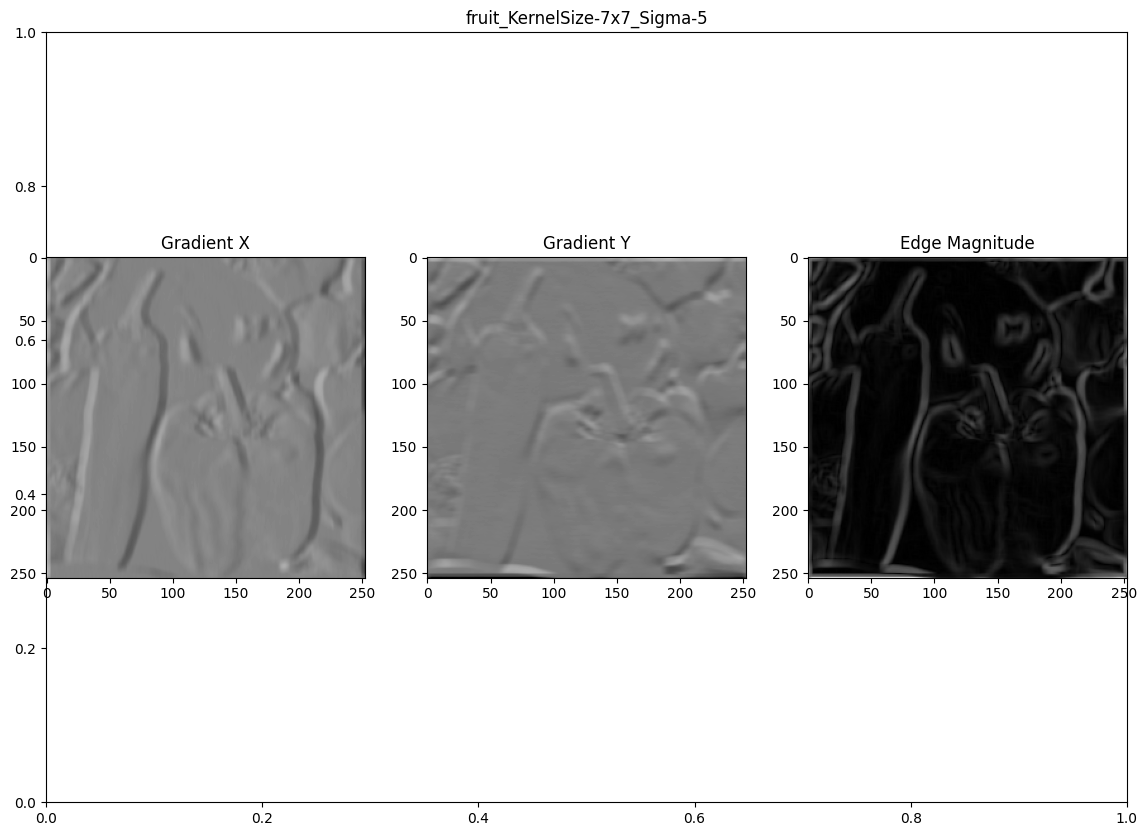

In [56]:
plot_gradients_and_magnitude(img_list=img_list, title=img_name, gradient_x=gradient_x, gradient_y=gradient_y, edge_magnitude=edge_magnitude)

In [57]:
# Save Images with Sobel Filter Applied

f_n = f"{img_name}_{'SobelFilter'}-{'Gradient_X'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=gradient_x, width=width, height=height, max_val=max_val)

f_n = f"{img_name}_{'SobelFilter'}-{'Gradient_Y'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=gradient_y, width=width, height=height, max_val=max_val)

f_n = f"{img_name}_{'SobelFilter'}-{'EdgeMagnitude'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=edge_magnitude, width=width, height=height, max_val=max_val)

## Image-3: saturn.ascii.pgm

### Read Image

In [58]:
# Show Each Image Name & Path
img_name, img_path = img_list[2][0], img_list[2][1]
print(f"ImageName: {img_name} & ImagePath: {img_path}")

# Create Specific Directory for Filtered Images
os.makedirs(os.path.join(FILTERED_IMG_PATH,img_name), exist_ok=True)

ImageName: saturn.ascii.pgm & ImagePath: C:\Users\metin\Desktop\YTU\2024-Spring\3-BLM5113-SayisalVideoIsleme\HWorks\Hw1\images\saturn.ascii.pgm


In [59]:
img_arr, width, height, max_val = read_p2_pgm_image(file_name=img_path)

In [60]:
img_arr.shape, width, height, max_val

((480, 640), 640, 480, 255)

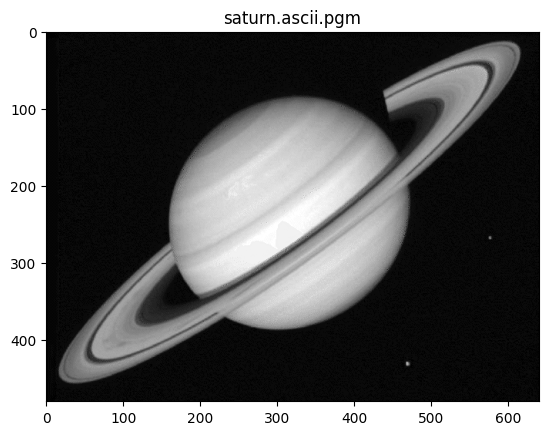

In [61]:
plt.imshow(img_arr, cmap="gray")
plt.title(img_name)
plt.show()

### Apply Gaussian Kernel

In [62]:
img_arr_gaussian_filtered = apply_gaussian_filter(image=img_arr, sigma=1, size=1)
img_arr_gaussian_filtered

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 8, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 8, 8, 0],
       [0, 0, 8, ..., 8, 8, 0],
       [0, 0, 0, ..., 8, 8, 0]])

In [63]:
# img_arr

In [64]:
# plt.imshow(img_arr, cmap="gray")

In [65]:
# plt.imshow(img_arr_gauss_filtered, cmap="gray")

In [66]:
# Set Kernel Size and Sigma Values

kernel_sizes = [3, 5, 7]
sigmas = [1, 5]

kernel_sigma_values = [(a, b) for a in kernel_sizes for b in sigmas]
kernel_sigma_values

[(3, 1), (3, 5), (5, 1), (5, 5), (7, 1), (7, 5)]

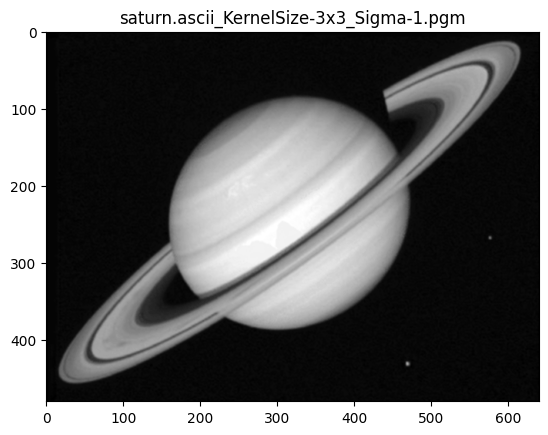

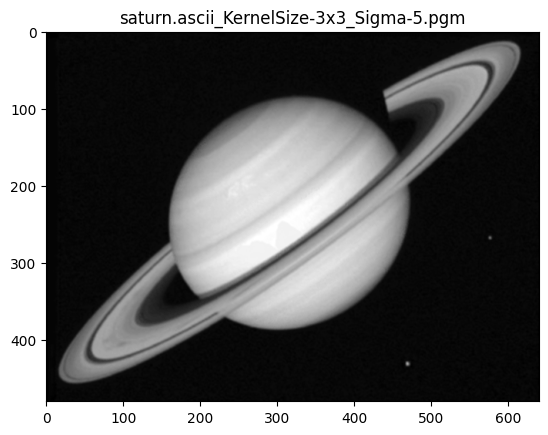

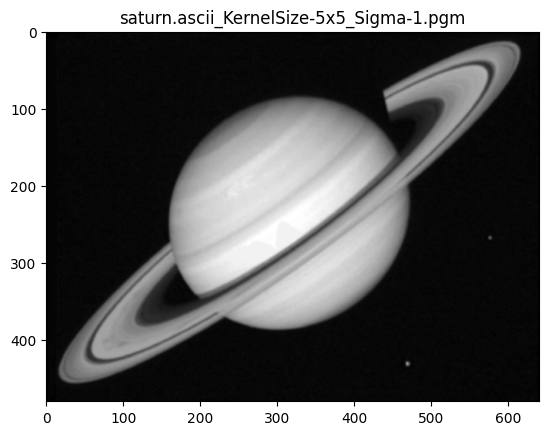

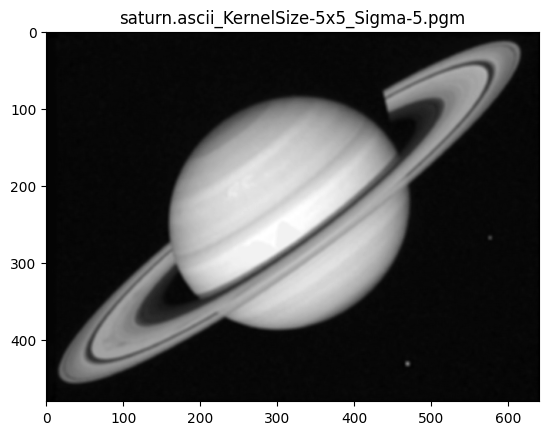

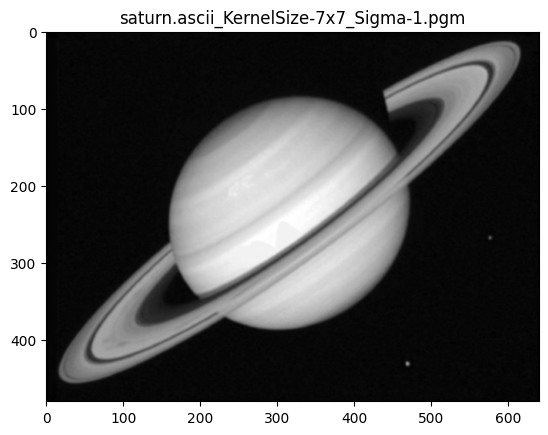

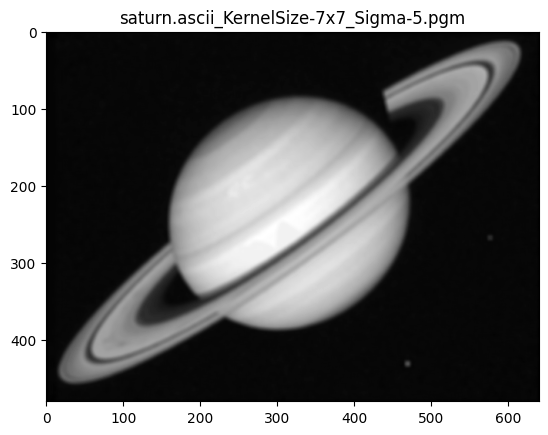

In [67]:
file_name, file_ext = os.path.splitext(img_name)[0], os.path.splitext(img_name)[1]

for i in kernel_sigma_values:
    img_filtered = apply_gaussian_filter(img_arr, size=i[0], sigma=i[1])
    f_n = f"{file_name}_KernelSize-{i[0]}x{i[0]}_Sigma-{i[1]}{file_ext}"
    f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
    write_pgm(file_name=f_p, image=img_filtered, width=width, height=height, max_val=max_val)
    plt.figure()
    plt.imshow(img_filtered, cmap="gray")
    plt.title(f_n)
    plt.show()

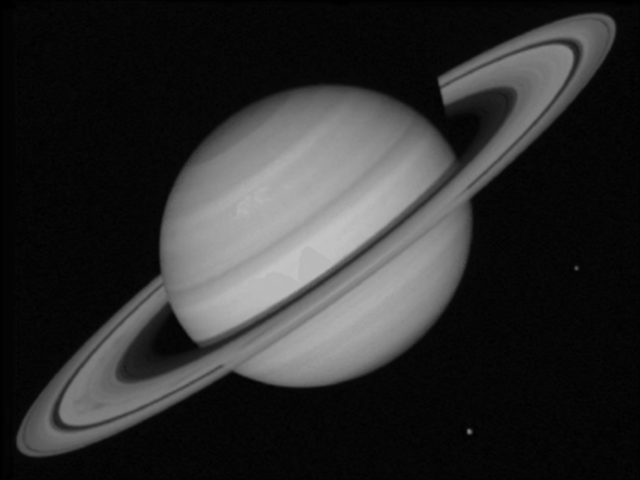

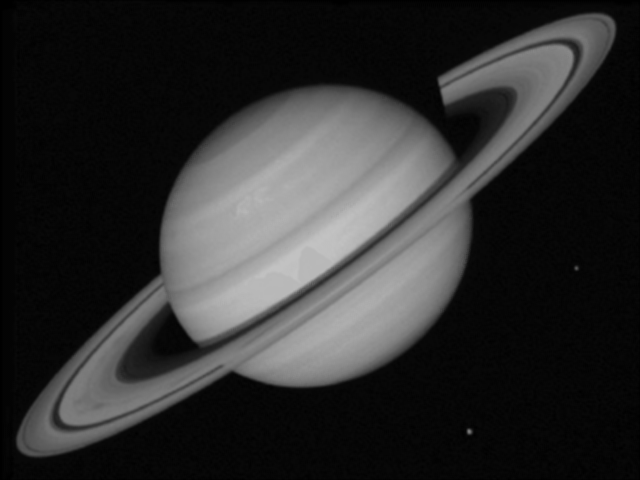

In [68]:
display_pgm(file_name="filtered/saturn.ascii.pgm/saturn.ascii_KernelSize-3x3_Sigma-1.pgm")
display_pgm(file_name="filtered/saturn.ascii.pgm/saturn.ascii_KernelSize-3x3_Sigma-5.pgm")

### Apply Sobel Filter

In [69]:
gradient_x, gradient_y, edge_magnitude = apply_sobel_filter(img_arr)

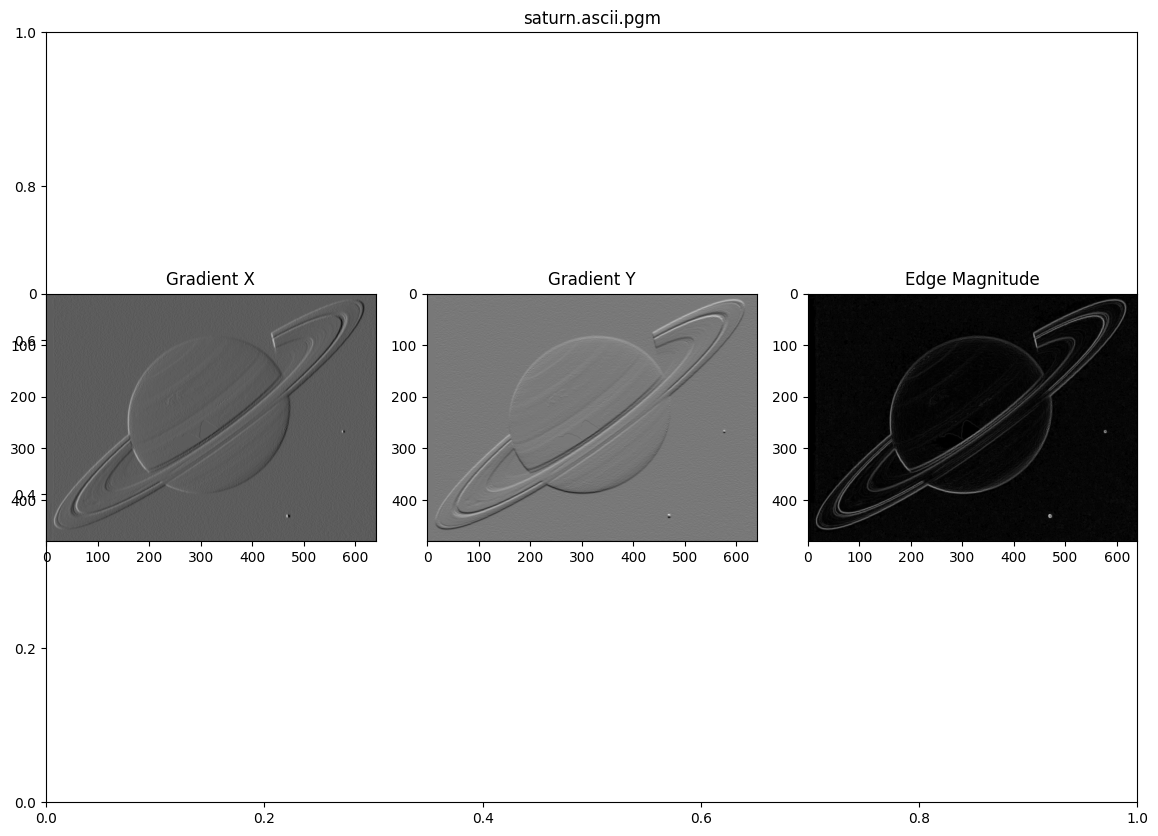

In [70]:
plot_gradients_and_magnitude(img_list=img_list, title=img_name, gradient_x=gradient_x, gradient_y=gradient_y, edge_magnitude=edge_magnitude)

In [71]:
# Save Images with Sobel Filter Applied

f_n = f"{file_name}_{'SobelFilter'}-{'Gradient_X'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=gradient_x, width=width, height=height, max_val=max_val)

f_n = f"{file_name}_{'SobelFilter'}-{'Gradient_Y'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=gradient_y, width=width, height=height, max_val=max_val)

f_n = f"{file_name}_{'SobelFilter'}-{'EdgeMagnitude'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name, f_n)
write_pgm(file_name=f_p, image=edge_magnitude, width=width, height=height, max_val=max_val)

In [72]:
# plt.figure()
# plt.imshow(gradient_y, cmap="gray")
# plt.title(str(img_name) + "---" + str("gradient_y"))
# plt.show()

### Apply Sobel Filter to Most Blurry Image

In [73]:
most_blurry_image = "filtered/saturn.ascii.pgm/saturn.ascii_KernelSize-7x7_Sigma-5.pgm"

img_name = os.path.splitext("saturn.ascii_KernelSize-7x7_Sigma-5.pgm")[0]
img_path = most_blurry_image

print(f"ImageName: {img_name} & ImagePath: {img_path}")

# Create Specific Directory for Filtered Images
img_name_ = "most_blurry_image"
os.makedirs(os.path.join(FILTERED_IMG_PATH, img_name_), exist_ok=True)

ImageName: saturn.ascii_KernelSize-7x7_Sigma-5 & ImagePath: filtered/saturn.ascii.pgm/saturn.ascii_KernelSize-7x7_Sigma-5.pgm


#### Read Image

In [74]:
img_arr, width, height, max_val = read_p2_pgm_image(file_name=img_path)

In [75]:
img_arr.shape, width, height, max_val

((480, 640), 640, 480, 255)

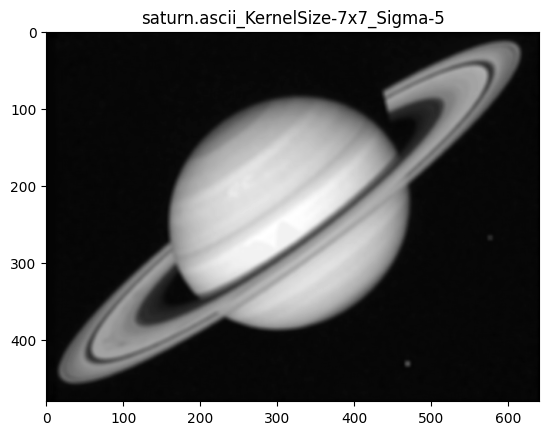

In [76]:
plt.imshow(img_arr, cmap="gray")
plt.title(img_name)
plt.show()

#### Apply Sobel Filter

In [77]:
gradient_x, gradient_y, edge_magnitude = apply_sobel_filter(img_arr)

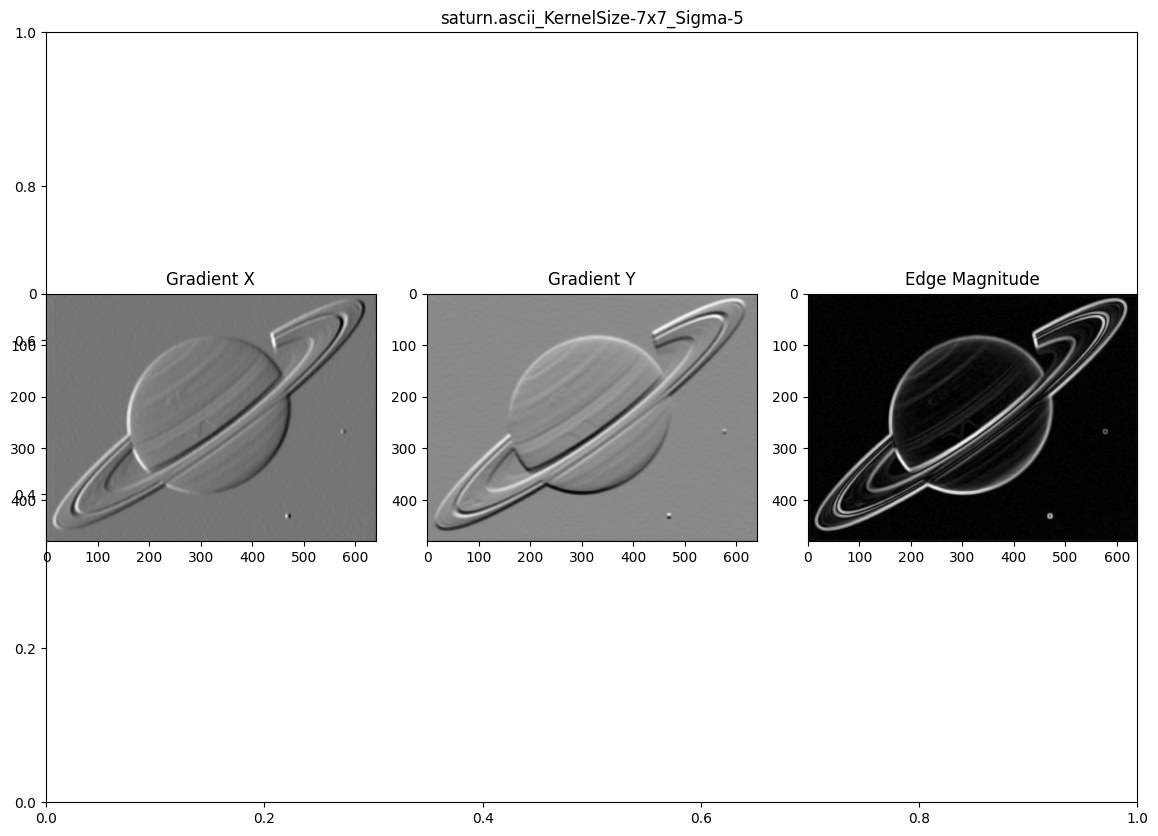

In [78]:
plot_gradients_and_magnitude(img_list=img_list, title=img_name, gradient_x=gradient_x, gradient_y=gradient_y, edge_magnitude=edge_magnitude)

In [79]:
# Save Images with Sobel Filter Applied

f_n = f"{img_name}_{'SobelFilter'}-{'Gradient_X'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=gradient_x, width=width, height=height, max_val=max_val)

f_n = f"{img_name}_{'SobelFilter'}-{'Gradient_Y'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=gradient_y, width=width, height=height, max_val=max_val)

f_n = f"{img_name}_{'SobelFilter'}-{'EdgeMagnitude'}{file_ext}"
f_p = os.path.join(FILTERED_IMG_PATH, img_name_, f_n)
write_pgm(file_name=f_p, image=edge_magnitude, width=width, height=height, max_val=max_val)